# Age recognition 

**Authors**: Richard Šléher, Tomáš Majerník

**Dataset**: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset/code?select=train.csv 

**EDA Lib**: https://pypi.org/project/summarytools/

For formatting: Ruff + Black

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from summarytools import dfSummary
from timm import create_model
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

warnings.filterwarnings("ignore")


c:\Users\risko\miniconda3\envs\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Hyperparameters

In [2]:
IMAGE_SIZE = 128
batch_size = 256
num_epochs = 50

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## EDA

In [4]:
data = pd.read_csv("data/train.csv")

In [5]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 9896.jpg2. 377.jpg3. 7038.jpg4. 10812.jpg5. 11803.jpg6. 22630.jpg7. 9733.jpg8. 6149.jpg9. 10025.jpg10. 14939.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)19,896 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"10,804 (54.3%)6,706 (33.7%)2,396 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


<Axes: xlabel='Class', ylabel='Count'>

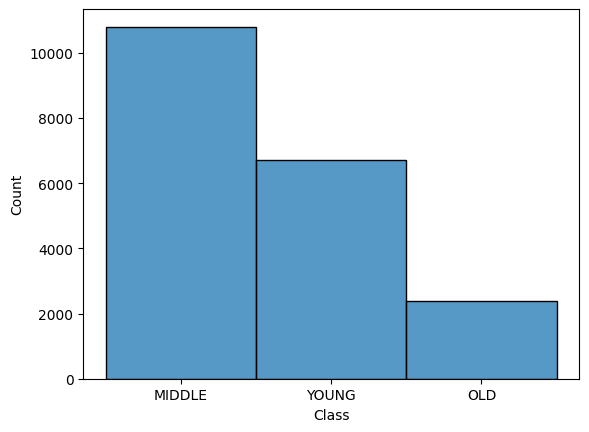

In [6]:
sns.histplot(data["Class"])

Máme nepomer tried, čiže pri trénovaní modelu sme nastavili rozdielne weighty pre triedy aby sme "vyrovnali" tento nepomer.

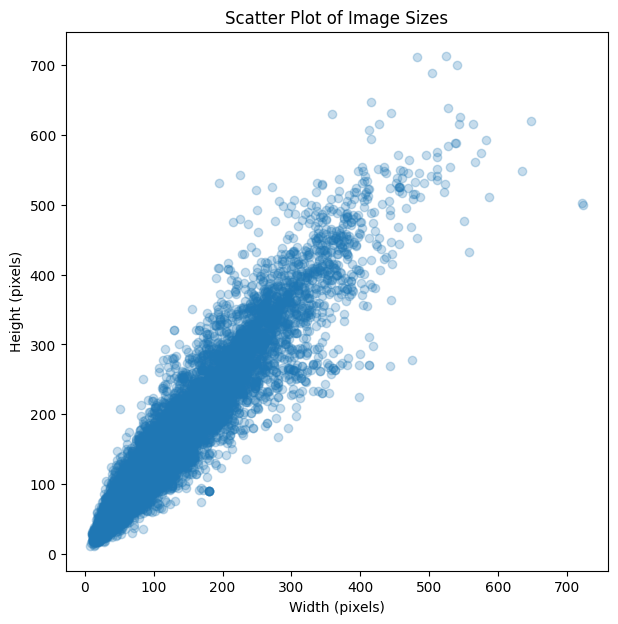

In [7]:
image_sizes = []

for img_id in data["ID"]:
    img_path = os.path.join("data/train/", img_id)
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
    except Exception as e:
        print(f"Error processing file {img_path}: {e}")

if image_sizes:
    widths, heights = zip(*image_sizes, strict=False)

    # Create a scatter plot
    plt.figure(figsize=(7, 7))
    plt.scatter(widths, heights, alpha=0.25)
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.title("Scatter Plot of Image Sizes")
    plt.show()
else:
    print("No image sizes were processed.")

Scatterplot distribúcie veľkostí obrázkov. Môžeme pozorovať, že obrázky majú veľký rozsah veľkostí.

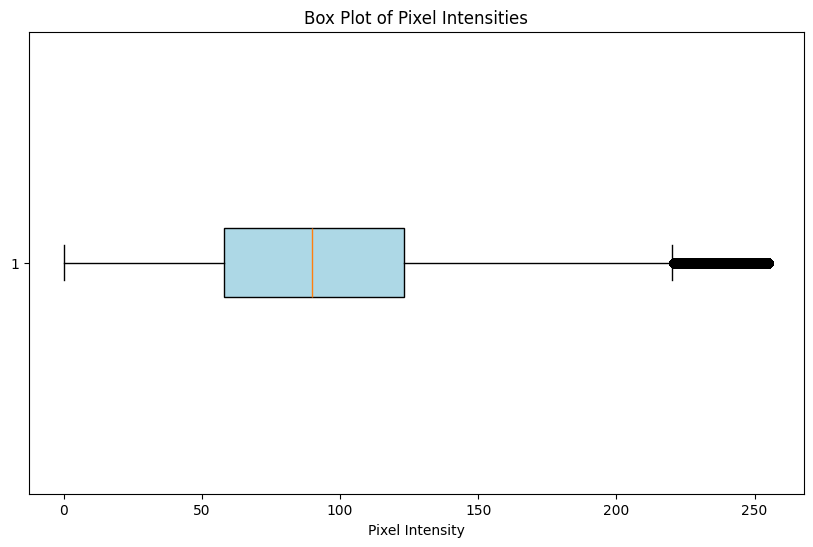

In [8]:
pixel_intensities = []

for img_id in data["ID"]:
    img_path = os.path.join("data/train/", img_id)
    try:
        with Image.open(img_path) as img:
            grayscale_img = img.convert("L")
            pixel_intensities.append(np.array(grayscale_img).flatten())
    except Exception as e:
        print(f"Error processing file {img_path}: {e}")

if pixel_intensities:
    combined_intensities = np.concatenate(pixel_intensities)

    plt.figure(figsize=(10, 6))
    plt.boxplot(
        combined_intensities,
        vert=False,
        patch_artist=True,
        boxprops={"facecolor": "lightblue"},
    )
    plt.xlabel("Pixel Intensity")
    plt.title("Box Plot of Pixel Intensities")
    plt.show()
else:
    print("No pixel intensities were processed.")

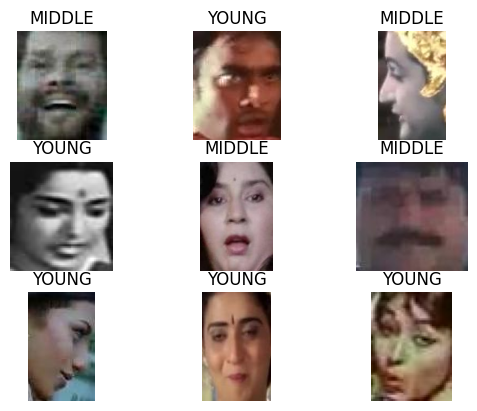

In [9]:
fig = plt.figure()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread("data/train/" + data.iloc[i]["ID"])
    plt.imshow(img)
    plt.title(data.iloc[i]["Class"])
    plt.axis("off")

plt.show()

In [10]:
X = data["ID"]
y = data["Class"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, shuffle=True, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=42
)

In [11]:
X_train_df = pd.DataFrame(X_train)
X_train_df["Target"] = y
dfSummary(X_train_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 1408.jpg2. 18855.jpg3. 13392.jpg4. 3167.jpg5. 8817.jpg6. 7576.jpg7. 20124.jpg8. 21497.jpg9. 10765.jpg10. 8691.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)13,924 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Target[object],1. MIDDLE2. YOUNG3. OLD,"7,563 (54.3%)4,694 (33.7%)1,677 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [12]:
X_test_df = pd.DataFrame(X_test)
X_test_df["Target"] = y_test
dfSummary(X_test_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 9310.jpg2. 19933.jpg3. 18499.jpg4. 25215.jpg5. 18971.jpg6. 18315.jpg7. 18431.jpg8. 21207.jpg9. 4922.jpg10. 20882.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)2,976 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Target[object],1. MIDDLE2. YOUNG3. OLD,"1,621 (54.3%)1,006 (33.7%)359 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [13]:
X_val_df = pd.DataFrame(X_val)
X_val_df["Target"] = y_val
dfSummary(X_val_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 13314.jpg2. 955.jpg3. 2694.jpg4. 11877.jpg5. 22239.jpg6. 16197.jpg7. 6277.jpg8. 12321.jpg9. 1925.jpg10. 17901.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)2,976 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Target[object],1. MIDDLE2. YOUNG3. OLD,"1,620 (54.3%)1,006 (33.7%)360 (12.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [14]:
image_data = []

for filename in os.listdir("./data/Train/"):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join("./data/Train/", filename)
        with Image.open(image_path) as image:
            image_data.append(
                {
                    "filename": filename,
                    "width": image.width,
                    "height": image.height,
                    "mode": image.mode,
                    "image": image,
                }
            )

        df = pd.DataFrame(image_data)

print(df.head())

    filename  width  height mode  \
0      0.jpg     68      69  RGB   
1      1.jpg    309     387  RGB   
2    100.jpg     98     168  RGB   
3  10000.jpg    115     137  RGB   
4  10001.jpg    105     162  RGB   

                                               image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  


In [15]:
print("Width Stats:")
print(df["width"].describe())
print("Height Stats:")
print(df["height"].describe())

df["aspect_ratio"] = df["width"] / df["height"]
print("Aspect Ratio Stats:")
print(df["aspect_ratio"].describe())

print("Image Modes Count:")
print(df["mode"].value_counts())

Width Stats:
count    19906.000000
mean        99.010700
std         78.192463
min          8.000000
25%         43.000000
50%         75.000000
75%        129.000000
max        724.000000
Name: width, dtype: float64
Height Stats:
count    19906.000000
mean       125.467246
std         92.986340
min         11.000000
25%         59.000000
50%         97.000000
75%        163.000000
max        713.000000
Name: height, dtype: float64
Aspect Ratio Stats:
count    19906.000000
mean         0.782291
std          0.160539
min          0.246377
25%          0.687566
50%          0.775060
75%          0.861829
max          2.333333
Name: aspect_ratio, dtype: float64
Image Modes Count:
mode
RGB    19906
Name: count, dtype: int64


In [16]:
class AgeDataset(Dataset):
    def __init__(self, filenames: str, labels: str, transform: transforms.Compose=None) -> None:
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
        self.label_mapping = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> tuple:
        img_name = os.path.join("data/train/", self.filenames.iloc[idx])
        image = Image.open(img_name).convert("RGB")
        label = self.labels.iloc[idx]
        label = self.label_mapping[label]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)


train_dataset = AgeDataset(filenames=X_train, labels=y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = AgeDataset(filenames=X_val, labels=y_val, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = AgeDataset(filenames=X_test, labels=y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Dané transofrmácie sme vybrali na základe toho, že sa najviac hodia na normalizáciu násho typu obrázkov. Pretože, keď máme tvár nemôžeme ju otočiť napr. o 180 stupňov, lebo by si daný model mýlil oči s ústami napríklad. Horizontal flip a color jitter sú mierne transformácie aby sa model nenaučil iba na jeden uhol alebo jednu farbu pleti.

Source: https://pytorch.org/vision/0.15/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

## 1. Custom CNN 

In [17]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, num_classes)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = F.relu(self.fc4(x))
        s = self.dropout3(x)
        x = self.fc5(x)

        return x


Ako prvý model sme vytvorili klasickú konvolučnú sieť, kktorá obsahuje štyri konvolučné vrstvy so zmenšujúcimi sa max-pooling vrstvami na extrakciu obrazových čŕt a zníženie rozmerov. Po konvolučných vrstvách nasledujú štyri fully-connected vrstvy, pričom medzi nimi sa používajú Dropout vrstvy na zníženie rizika pretrénovania. Výstup je generovaný pomocou poslednej lineárnej vrstvy, ktorá mapuje extrahované črty na počet tried špecifikovaných parametrom num_classes.

In [18]:
model = CNN(in_channels=3, num_classes=3).to(device=device)

In [19]:
def evaluate(model: CNN, val_loader: DataLoader, criterion: nn.CrossEntropyLoss) -> tuple:
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    return val_loss / len(val_loader), accuracy, precision, recall, f1

In [20]:
class_weights = torch.tensor([1.0, 2.0, 3.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
wandb.init(
    project="age-recognition",
    name="Custom-CNN",
    config={
        "model": "Custom-CNN",
        "learning_rate": 1e-4,
        "batch_size": batch_size,
        "epochs": num_epochs
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: riso-sleher (riso-sleher-fiit-stu). Use `wandb login --relogin` to force relogin


In [ ]:
# Training loop
model.to(device)

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    val_loss, val_accuracy, precision, recall, f1 = evaluate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_accuracies.append(train_accuracy)

    wandb.log({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "f1": f1,
    })

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f},\
    Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f},\
    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}"
    )

    scheduler.step()

torch.save(model.state_dict(), "CNN.pth")

Epoch 1/50, Train Loss: 0.896, Val Loss: 0.819,    Train Accuracy: 0.551, Val Accuracy: 0.613,    Precision: 0.572, Recall: 0.613, F1: 0.537
Epoch 2/50, Train Loss: 0.776, Val Loss: 0.788,    Train Accuracy: 0.624, Val Accuracy: 0.639,    Precision: 0.651, Recall: 0.639, F1: 0.644
Epoch 3/50, Train Loss: 0.732, Val Loss: 0.711,    Train Accuracy: 0.653, Val Accuracy: 0.686,    Precision: 0.687, Recall: 0.686, F1: 0.679
Epoch 4/50, Train Loss: 0.703, Val Loss: 0.691,    Train Accuracy: 0.671, Val Accuracy: 0.667,    Precision: 0.692, Recall: 0.667, F1: 0.637
Epoch 5/50, Train Loss: 0.690, Val Loss: 0.703,    Train Accuracy: 0.674, Val Accuracy: 0.642,    Precision: 0.694, Recall: 0.642, F1: 0.637
Epoch 6/50, Train Loss: 0.671, Val Loss: 0.684,    Train Accuracy: 0.688, Val Accuracy: 0.660,    Precision: 0.699, Recall: 0.660, F1: 0.632
Epoch 7/50, Train Loss: 0.659, Val Loss: 0.651,    Train Accuracy: 0.697, Val Accuracy: 0.711,    Precision: 0.728, Recall: 0.711, F1: 0.706
Epoch 8/50, T

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1,▁▄▆▄▄▆▅▅▇▇▇▇█▇██████████████████████████
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇███████████████████████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▄▂▆▅▅▇▇▇▇▇▇▇██▇███▇█████████████▇████
val_loss,█▆▅▅▅▄▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁
epoch,50
f1,0.75201
train_accuracy,0.75736
train_loss,0.53487
val_accuracy,0.75519


In [ ]:
wandb.finish()

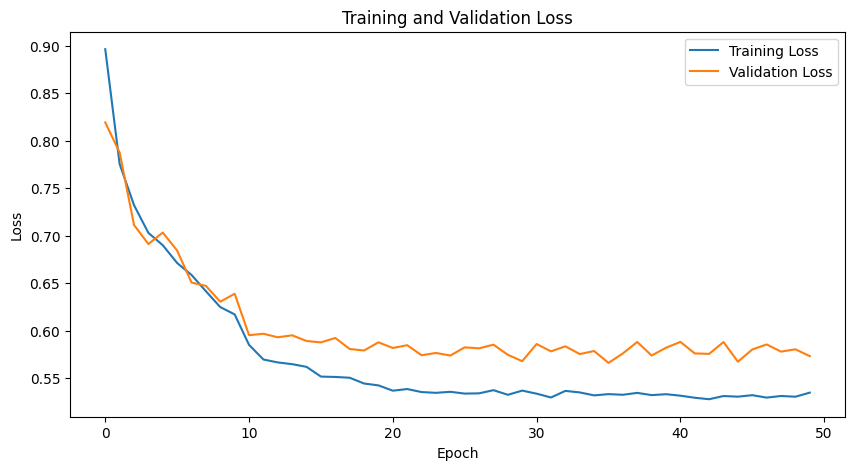

In [23]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

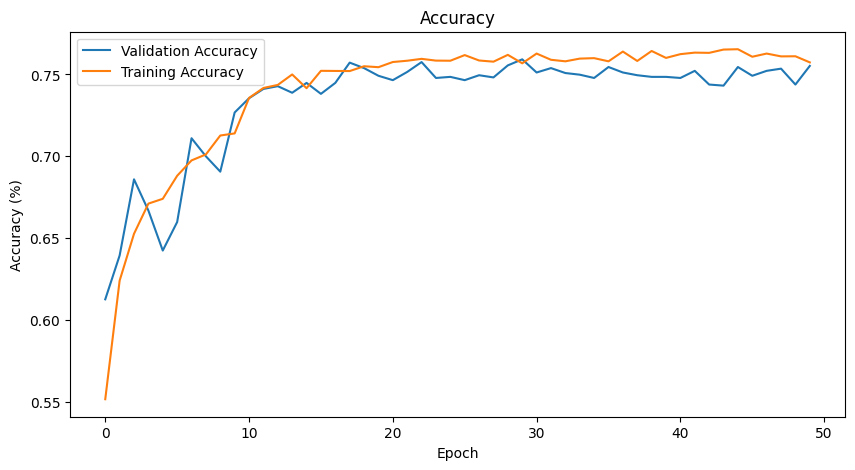

In [24]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy")
plt.show()

Z výsledkov vidíme, že sa nám prestal zlepšovať model približne od 20 epochu.

## 2. Custom CNN

In [25]:
conv_base = create_model("xception", pretrained=True, num_classes=0)
conv_base.global_pool = nn.Identity()


class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = conv_base
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.batch_norm1 = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.batch_norm1(x)
        x = F.relu(self.fc1(x))
        x = self.batch_norm2(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.batch_norm3(x)
        x = self.dropout2(x)
        x = self.output(x)
        return F.softmax(x, dim=1)


num_classes = 3
model = CustomModel(num_classes=num_classes).to(device=device)

Tento model využíva predtrénovanú sieť Xception ako základ pre extrakciu čŕt, čiže ako konvolučnú časť požívame Xception, pričom jej globálna pooling vrstva je nahradená identitou, aby sa zachovali výstupné mapy čŕt. Po extrakcii čŕt sa pridáva globálna AdaptiveAvgPool2d, po ktorej nasledujú dve fully-connected vrstvy s veľkosťami 256 a 128 neurónov, s Batch Normalization a Dropout pre regularizáciu. Výstupná lineárna vrstva mapuje na počet tried (num_classes), pričom model generuje pravdepodobnosti použitím funkcie softmax.

In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
class_weights = torch.tensor([1.0, 2.0, 3.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [27]:
wandb.init(
    project="age-recognition",
    name="Custom-CNN_Xception",
    config={
        "model": "Custom-CNN_Xception",
        "learning_rate": 1e-4,
        "batch_size": batch_size,
        "epochs": num_epochs-40
    }
)

In [ ]:
train_losses = []
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

for epoch in range(num_epochs-40):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    val_loss, val_accuracy, precision, recall, f1 = evaluate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_accuracies.append(train_accuracy)

    wandb.log({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "f1": f1,
    })

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f},\
    Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f},\
    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}"
    )

    scheduler.step()

torch.save(model.state_dict(), "CNN_Xception.pth")

Epoch 1/50, Train Loss: 0.999, Val Loss: 0.888,    Train Accuracy: 0.530, Val Accuracy: 0.665,    Precision: 0.685, Recall: 0.665, F1: 0.665
Epoch 2/50, Train Loss: 0.872, Val Loss: 0.836,    Train Accuracy: 0.678, Val Accuracy: 0.723,    Precision: 0.721, Recall: 0.723, F1: 0.718
Epoch 3/50, Train Loss: 0.819, Val Loss: 0.812,    Train Accuracy: 0.737, Val Accuracy: 0.737,    Precision: 0.744, Recall: 0.737, F1: 0.727
Epoch 4/50, Train Loss: 0.787, Val Loss: 0.788,    Train Accuracy: 0.761, Val Accuracy: 0.765,    Precision: 0.766, Recall: 0.765, F1: 0.760
Epoch 5/50, Train Loss: 0.760, Val Loss: 0.783,    Train Accuracy: 0.788, Val Accuracy: 0.760,    Precision: 0.769, Recall: 0.760, F1: 0.758
Epoch 6/50, Train Loss: 0.746, Val Loss: 0.765,    Train Accuracy: 0.802, Val Accuracy: 0.781,    Precision: 0.785, Recall: 0.781, F1: 0.779
Epoch 7/50, Train Loss: 0.730, Val Loss: 0.750,    Train Accuracy: 0.814, Val Accuracy: 0.797,    Precision: 0.802, Recall: 0.797, F1: 0.795
Epoch 8/50, T

epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▃▄▅▅▆▇▇██
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▄▆▅▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
f1,0.81544
train_accuracy,0.85761
train_loss,0.68623
val_accuracy,0.81815


In [ ]:
wandb.finish()

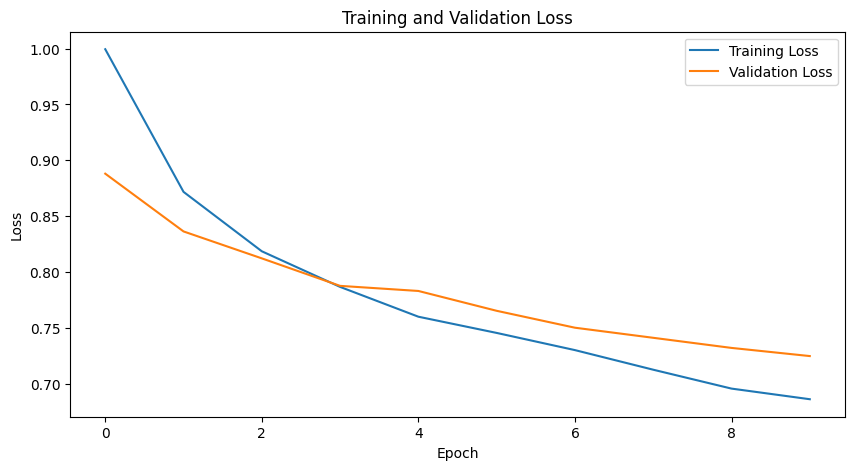

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

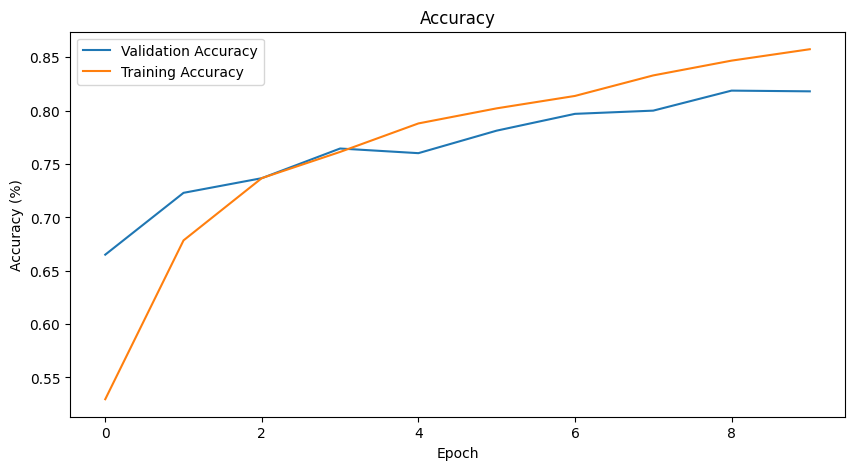

In [30]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy")
plt.show()

Z výsledkov vidíme, že daný model sa stále učil a kebyže ho necháme pustený viac epochov možno by dosiahol vyššie výsledky. 

## 3. Resnet-18 - pretrained

Source: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [46]:
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 3)

model = model_resnet.to(device)

Tento model používa ResNet-18 ako základnú sieť s predtrénovanými váhami na extrakciu čŕt. Pôvodná plne prepojená výstupná vrstva je nahradená novou lineárnou vrstvou s tromi výstupmi, čo umožňuje klasifikáciu do troch tried. Model zachováva architektúru ResNet-18 s reziduálnymi blokmi pre efektívne učenie a rýchlu konvergenciu.

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [48]:
wandb.init(
    project="age-recognition",
    name="Resnet-18",
    config={
        "model": "Resnet-18",
        "learning_rate": 1e-3,
        "batch_size": batch_size,
        "epochs": num_epochs-40
    }
)

In [49]:
train_losses = []
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

for epoch in range(num_epochs-40):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    val_loss, val_accuracy, precision, recall, f1 = evaluate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_accuracies.append(train_accuracy)

    wandb.log({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "f1": f1,
    })

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f},\
    Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f},\
    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}"
    )

    scheduler.step()

torch.save(model.state_dict(), "resnet.pth")

Epoch 1/50, Train Loss: 0.786, Val Loss: 0.626,    Train Accuracy: 0.669, Val Accuracy: 0.740,    Precision: 0.732, Recall: 0.740, F1: 0.731
Epoch 2/50, Train Loss: 0.565, Val Loss: 0.587,    Train Accuracy: 0.759, Val Accuracy: 0.747,    Precision: 0.753, Recall: 0.747, F1: 0.745
Epoch 3/50, Train Loss: 0.499, Val Loss: 0.544,    Train Accuracy: 0.792, Val Accuracy: 0.776,    Precision: 0.775, Recall: 0.776, F1: 0.765
Epoch 4/50, Train Loss: 0.450, Val Loss: 0.481,    Train Accuracy: 0.815, Val Accuracy: 0.804,    Precision: 0.809, Recall: 0.804, F1: 0.805
Epoch 5/50, Train Loss: 0.391, Val Loss: 0.516,    Train Accuracy: 0.843, Val Accuracy: 0.800,    Precision: 0.803, Recall: 0.800, F1: 0.795
Epoch 6/50, Train Loss: 0.354, Val Loss: 0.482,    Train Accuracy: 0.857, Val Accuracy: 0.806,    Precision: 0.811, Recall: 0.806, F1: 0.805
Epoch 7/50, Train Loss: 0.318, Val Loss: 0.501,    Train Accuracy: 0.877, Val Accuracy: 0.800,    Precision: 0.800, Recall: 0.800, F1: 0.793
Epoch 8/50, T

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [51]:
wandb.finish()

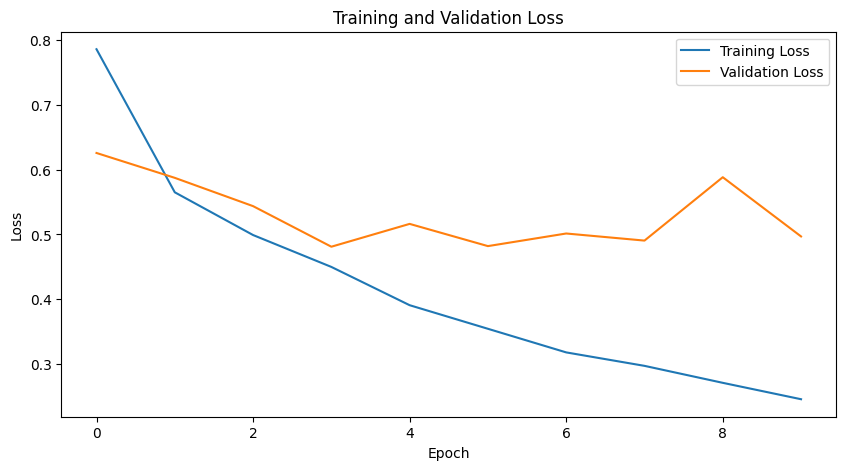

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

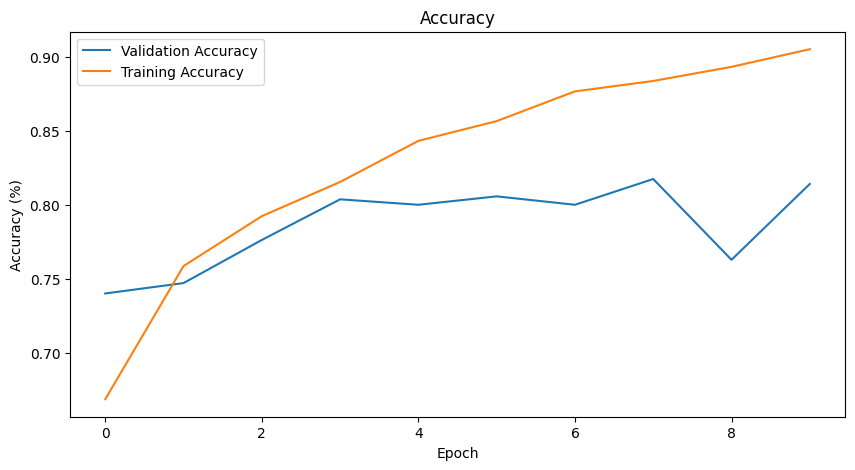

In [53]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy")
plt.show()

Z výsledkov vidíme, že model je overfitnutý. Dalo by sa to napraviť upravením/pridaním dropoutu.

## Our face prediction using Resnet-18

In [54]:
def predict_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

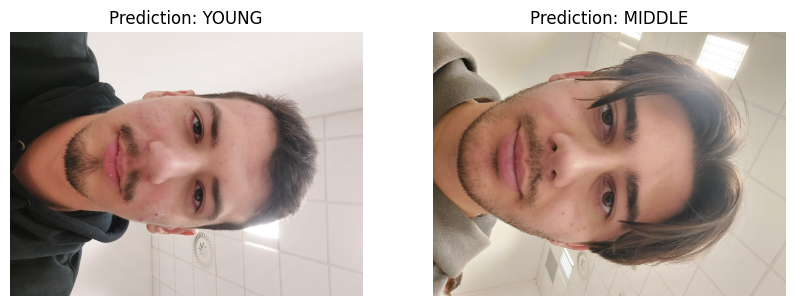

In [61]:
image_paths = ["riso.jpg", "tomas.jpg"]
predictions = []

for image_path in image_paths:
    prediction = predict_image(model, image_path, transform, device)
    predictions.append(prediction)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
label_mapping = {0: "YOUNG", 1: "MIDDLE", 2: "OLD"}

for ax, image_path, prediction in zip(axes, image_paths, predictions, strict=False):
    image = plt.imread(image_path)
    ax.imshow(image)
    ax.set_title(f"Prediction: {label_mapping[prediction]}")
    ax.axis("off")

plt.show()

## Záver

Po porovnaní 3 modelov sme dosiahli záver, že predtrénovaný resnet-18 sme nedokázali presiahnuť ale je overfitnutý. Výsledky by sa dali zlepšiť lepšími transformáciami dát. Bez použitia transformácií sa dá dosiahnuť vysoká presnosť na trénovacej množine ale s overfittingom. Zaujímavé by bolo dotrénovanie druhého modelu na 20-25 epochov ale trvalo by to príliš dlho. 